# e23 Terrain Graph 2 Analysis

This notebook fetches runs from wandb tagged with `e23TG_neurogf_terrain_graph_2` and creates analysis plots.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import wandb_buddy as wb

## Notebook parameters

In [83]:
# Fetch runs with the specified tag
TAG = "e23TG_neurogf_terrain_graph_2"
ENTITY = "alelab"
PROJECT = "terrains"

# Use test_mae (computed from history) as the error metric
ERROR_COL = 'test_mae'
ERROR_LABEL = 'Test MAE'

## Fetch Runs from Wandb by Tag


In [ ]:


print(f"Fetching runs with tag: {TAG}")
df = wb.load_runs(ENTITY, PROJECT, tags=[TAG])
print(f"Found {len(df)} runs")

Fetching runs with tag: e23TG_neurogf_terrain_graph_2
Found 52 runs


In [52]:
df.head()

,name,id,state,created_at,heartbeat_at,tags,sweep_id,p,vn,new,...,sparse_gt_dropout,sparse_gt_num_hops,sparse_gt_input_dim,sparse_gt_num_heads,sparse_gt_hidden_dim,sparse_gt_num_layers,sparse_gt_output_dim,sparse_gt_attn_dropout,sparse_gt_rpearl_samples,sparse_gt_rpearl_num_layers
0,terrain-graph-TAGConv-res40-stage1,80eg729n,finished,2026-01-13T22:53:36Z,2026-01-14T02:54:20Z,"[TAGConv, e23TG_neurogf_terrain_graph_2, stage...",None,4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,terrain-graph-TAGConv-res40-stage1,8jrt6fb2,finished,2026-01-14T19:05:41Z,2026-01-14T20:03:44Z,"[TAGConv, e23TG_neurogf_terrain_graph_2, stage...",None,4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,terrain-graph-TAGConv-res40-stage1,8mmk9223,finished,2026-01-15T14:40:11Z,2026-01-17T12:19:12Z,"[TAGConv, e23TG_neurogf_terrain_graph_2, stage...",None,4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,terrain-graph-TAGConv-res36-stage1,sdg80scu,finished,2026-01-15T14:40:14Z,2026-01-17T12:14:32Z,"[TAGConv, e23TG_neurogf_terrain_graph_2, stage...",None,4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,terrain-graph-TAGConv-res37-stage1,0h390isk,finished,2026-01-15T14:40:15Z,2026-01-17T12:23:23Z,"[TAGConv, e23TG_neurogf_terrain_graph_2, stage...",None,4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Check available columns
print("Available columns:")
print(df.columns.tolist())

Available columns:
['name', 'id', 'state', 'created_at', 'heartbeat_at', 'tags', 'sweep_id', 'p', 'vn', 'new', 'aggr', 'trial', 'device', 'epochs', 'log_dir', 'siamese', 'finetune', 'loss_func', 'test_data', 'artificial', 'batch_size', 'layer_type', 'train_data', 'config_file', 'dataset_name', 'finetune_from', 'learning_rate', 'test_resolution', 'train_resolution', 'include_edge_attr', 'model_config_name', '_runtime', '_step', '_timestamp', '_wandb', 'epoch', 'final_train_loss', 'final_train_mae', 'final_train_mse', 'final_train_nmae', 'global_step', 'test_loss', 'test_mae', 'test_mse', 'test_nmae', 'train_loss', 'train_mae', 'train_mse', 'train_nmae', 'test_batch_loss', 'test_batch_mae', 'test_batch_mse', 'test_batch_nmae', 'val_loss', 'val_mae', 'val_mse', 'val_nmae', 'sparse_gt_dropout', 'sparse_gt_num_hops', 'sparse_gt_input_dim', 'sparse_gt_num_heads', 'sparse_gt_hidden_dim', 'sparse_gt_num_layers', 'sparse_gt_output_dim', 'sparse_gt_attn_dropout', 'sparse_gt_rpearl_samples', 'spa

In [54]:
# Extract resolution from dataset_name
def extract_resolution(row):
    dataset_name = str(row['dataset_name'])
    res_match = re.search(r'res(\d+)', dataset_name)
    return int(res_match.group(1))

df['resolution'] = df.apply(extract_resolution, axis=1)
print(f"Runs with valid resolution: {len(df)}")

Runs with valid resolution: 52


In [55]:
# Add density column (inverse of resolution squared)
df['density'] = 1 / (df['resolution'] ** 2)

print(f"Total runs: {len(df)}")
print(f"\nRuns by layer type:")
print(df['layer_type'].value_counts())
print(f"\nResolutions available:")
print(sorted(df['resolution'].unique()))

Total runs: 52

Runs by layer type:
layer_type
TAGConv     31
SparseGT    21
Name: count, dtype: int64

Resolutions available:
[np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40)]


## Compute Test MAE from Batch History

The training script logs `test_batch_mae` for each batch during the final test evaluation, but only the 
last value is captured in the run summary. To get the true test MAE, we need to fetch the full metric 
history from wandb and average over all logged batches.

This is necessary because:
1. `test_mae` (the summary metric) is only logged for runs that completed all epochs
2. `test_batch_mae` in the summary only contains the last batch's value, not the average
3. By fetching the history and averaging, we can compute the correct test MAE for all runs that started test evaluation

In [72]:
import wandb

def get_metric_history_mean(entity: str, project: str, run_id: str, metric: str) -> float:
    """
    Fetch the full history of a metric from a wandb run and return its mean.
    
    Args:
        entity: wandb entity/team name
        project: wandb project name  
        run_id: the run ID
        metric: name of the metric to fetch (e.g., 'test_batch_mae')
    
    Returns:
        Mean of all logged values for the metric, or NaN if no values exist
    """
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    history = run.history(keys=[metric], pandas=True)
    
    if history.empty or metric not in history.columns:
        return np.nan
    
    values = history[metric].dropna()
    if len(values) == 0:
        return np.nan
    
    return values.mean()


def add_metric_from_history(df: pd.DataFrame, entity: str, project: str, 
                            source_metric: str, target_col: str) -> pd.DataFrame:
    """
    Add a new column to df by fetching metric history from wandb and computing the mean.
    
    Args:
        df: DataFrame with 'id' column containing wandb run IDs
        entity: wandb entity name
        project: wandb project name
        source_metric: metric name to fetch from history (e.g., 'test_batch_mae')
        target_col: name of the new column to add (e.g., 'test_mae_from_history')
    
    Returns:
        DataFrame with new column added
    """
    from tqdm import tqdm
    
    means = []
    for run_id in tqdm(df['id'], desc=f"Fetching {source_metric} history"):
        mean_val = get_metric_history_mean(entity, project, run_id, source_metric)
        means.append(mean_val)
    
    df[target_col] = means
    return df

In [73]:
# Fetch test_batch_mae history and compute mean for each run
df = add_metric_from_history(df, ENTITY, PROJECT, 'test_batch_mae', 'test_mae')

print(f"Runs with valid test_mae (from history): {df['test_mae'].notna().sum()} / {len(df)}")
print(f"\nBy layer_type:")
print(df.groupby('layer_type')['test_mae'].apply(lambda x: f"{x.notna().sum()}/{len(x)} valid"))

Fetching test_batch_mae history: 100%|██████████| 52/52 [00:44<00:00,  1.18it/s]

Runs with valid test_mae (from history): 45 / 52

By layer_type:
layer_type
SparseGT    21/21 valid
TAGConv     24/31 valid
Name: test_mae, dtype: object


In [74]:
df[['id','created_at','state','resolution','density','layer_type','test_batch_mae','test_mae']].head(25).sort_values('created_at', ascending=True)

,id,created_at,state,resolution,density,layer_type,test_batch_mae,test_mae
0,80eg729n,2026-01-13T22:53:36Z,finished,40,0.000625,TAGConv,NaN,NaN
1,8jrt6fb2,2026-01-14T19:05:41Z,finished,40,0.000625,TAGConv,NaN,NaN
2,8mmk9223,2026-01-15T14:40:11Z,finished,40,0.000625,TAGConv,NaN,NaN
3,sdg80scu,2026-01-15T14:40:14Z,finished,36,0.000772,TAGConv,NaN,NaN
4,0h390isk,2026-01-15T14:40:15Z,finished,37,0.000730,TAGConv,NaN,NaN
5,itvp59om,2026-01-15T14:40:15Z,finished,39,0.000657,TAGConv,NaN,NaN
6,pehei5yb,2026-01-15T14:40:15Z,finished,38,0.000693,TAGConv,NaN,NaN
7,kk0krllh,2026-01-17T20:02:20Z,finished,39,0.000657,TAGConv,0.175213,0.165233
8,w50g89x2,2026-01-17T20:02:20Z,finished,40,0.000625,TAGConv,0.197514,0.187323
9,53oj07c9,2026-01-17T20:02:27Z,finished,38,0.000693,TAGConv,0.204143,0.195022


In [84]:


# Check how many runs have valid test_mae values
print(f"Runs with valid {ERROR_COL}: {df[ERROR_COL].notna().sum()} / {len(df)}")
print(f"\nBy layer_type:")
print(df.groupby('layer_type')[ERROR_COL].apply(lambda x: f"{x.notna().sum()}/{len(x)} valid"))

print("\nSample data:")
df[['name', 'layer_type', 'resolution', 'density', 'stage', ERROR_COL]].head(10)

Runs with valid test_mae: 45 / 52

By layer_type:
layer_type
SparseGT    21/21 valid
TAGConv     24/31 valid
Name: test_mae, dtype: object

Sample data:


,name,layer_type,resolution,density,stage,test_mae
0,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,NaN
1,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,NaN
2,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,NaN
3,terrain-graph-TAGConv-res36-stage1,TAGConv,36,0.000772,1,NaN
4,terrain-graph-TAGConv-res37-stage1,TAGConv,37,0.000730,1,NaN
5,terrain-graph-TAGConv-res39-stage1,TAGConv,39,0.000657,1,NaN
6,terrain-graph-TAGConv-res38-stage1,TAGConv,38,0.000693,1,NaN
7,terrain-graph-TAGConv-res39-stage1,TAGConv,39,0.000657,1,0.165233
8,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,0.187323
9,terrain-graph-TAGConv-res38-stage1,TAGConv,38,0.000693,1,0.195022


In [85]:
# Check all test-related columns and their coverage
test_cols = [c for c in df.columns if 'test' in c.lower()]
print("Test metric coverage by layer_type:\n")
for col in test_cols:
    valid_counts = df.groupby('layer_type')[col].apply(lambda x: x.notna().sum())
    total_counts = df.groupby('layer_type').size()
    print(f"{col}:")
    for lt in valid_counts.index:
        print(f"  {lt}: {valid_counts[lt]}/{total_counts[lt]}")
    print()

Test metric coverage by layer_type:

test_data:
  SparseGT: 21/21
  TAGConv: 31/31

test_resolution:
  SparseGT: 21/21
  TAGConv: 31/31

test_loss:
  SparseGT: 0/21
  TAGConv: 7/31

test_mae:
  SparseGT: 21/21
  TAGConv: 24/31

test_mse:
  SparseGT: 0/21
  TAGConv: 7/31

test_nmae:
  SparseGT: 0/21
  TAGConv: 7/31

test_batch_loss:
  SparseGT: 21/21
  TAGConv: 24/31

test_batch_mae:
  SparseGT: 21/21
  TAGConv: 24/31

test_batch_mse:
  SparseGT: 21/21
  TAGConv: 24/31

test_batch_nmae:
  SparseGT: 21/21
  TAGConv: 24/31



In [86]:
df.sort_values('resolution', ascending=False)[['name', 'layer_type', 'resolution', 'density', 'stage', ERROR_COL]]

,name,layer_type,resolution,density,stage,test_mae
0,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,NaN
1,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,NaN
2,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,NaN
8,terrain-graph-TAGConv-res40-stage1,TAGConv,40,0.000625,1,0.187323
15,terrain-graph-SparseGT-res40-stage1,SparseGT,40,0.000625,1,0.190540
14,terrain-graph-SparseGT-res39-stage1,SparseGT,39,0.000657,1,0.197511
7,terrain-graph-TAGConv-res39-stage1,TAGConv,39,0.000657,1,0.165233
5,terrain-graph-TAGConv-res39-stage1,TAGConv,39,0.000657,1,NaN
9,terrain-graph-TAGConv-res38-stage1,TAGConv,38,0.000693,1,0.195022
13,terrain-graph-SparseGT-res38-stage1,SparseGT,38,0.000693,1,0.197102


## Performance Plot


Available stages: [np.int64(1)]
Using 52 Stage 1 runs


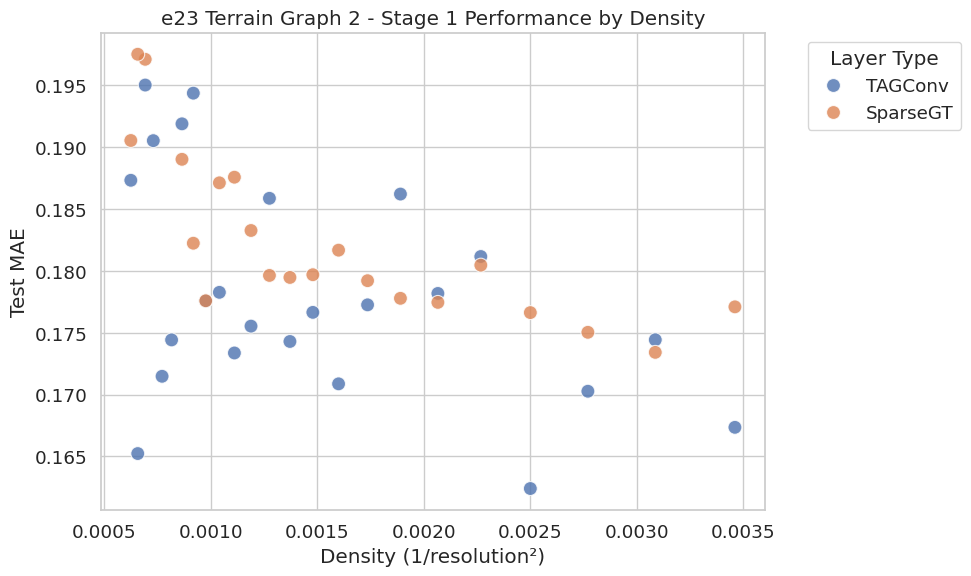

In [87]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)

# Get available stages
available_stages = sorted(df['stage'].dropna().unique())
print(f"Available stages: {available_stages}")

# Use all data if only stage 1 exists
df_plot = df[df['stage'] == 2] if 2 in available_stages else df
stage_label = "Stage 2" if 2 in available_stages else "Stage 1"
print(f"Using {len(df_plot)} {stage_label} runs")

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='density',
    y=ERROR_COL,
    hue='layer_type',
    s=100,
    alpha=0.8,
    ax=ax
)

ax.set_xlabel('Density (1/resolution²)')
ax.set_ylabel(ERROR_LABEL)
ax.set_title(f'e23 Terrain Graph 2 - {stage_label} Performance by Density')
ax.legend(title='Layer Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

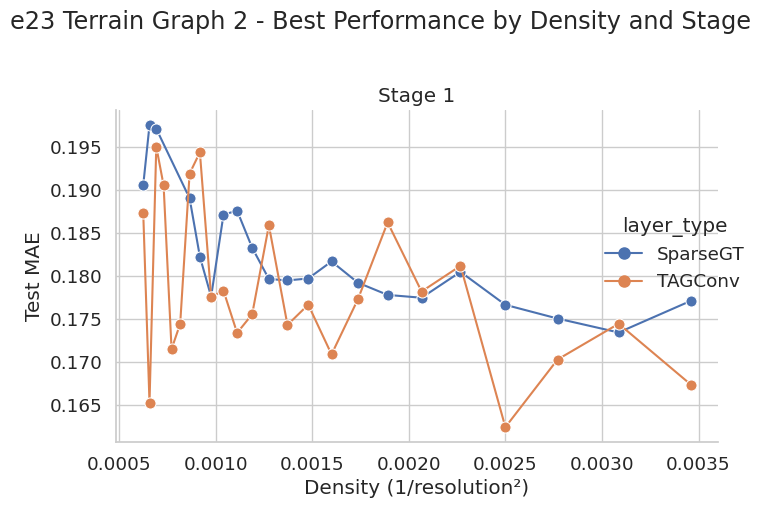

In [88]:
# Best performance per density per layer_type and stage
# Filter out rows with NaN in ERROR_COL before groupby to avoid KeyError
df_valid = df.dropna(subset=[ERROR_COL])
best_per_density = df_valid.loc[df_valid.groupby(['layer_type', 'density', 'stage'])[ERROR_COL].idxmin()]

g2 = sns.relplot(
    data=best_per_density,
    x='density',
    y=ERROR_COL,
    hue='layer_type',
    kind='line',
    col='stage',
    marker='o',
    markersize=8,
    height=5,
    aspect=1.2
)

g2.set_axis_labels('Density (1/resolution²)', ERROR_LABEL)
g2.set_titles('Stage {col_name}')
g2.fig.suptitle(f'e23 Terrain Graph 2 - Best Performance by Density and Stage', y=1.02)

plt.tight_layout()
plt.show()

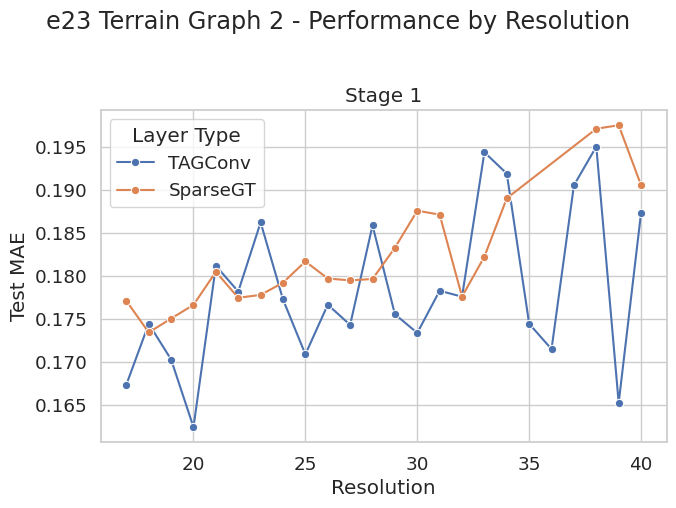

In [89]:
# Performance by resolution (easier to interpret)
n_stages = len(available_stages)
fig, axes = plt.subplots(1, n_stages, figsize=(7*n_stages, 5))
if n_stages == 1:
    axes = [axes]

for idx, stage in enumerate(available_stages):
    df_stage = df[df['stage'] == stage]
    ax = axes[idx]
    
    sns.lineplot(
        data=df_stage,
        x='resolution',
        y=ERROR_COL,
        hue='layer_type',
        marker='o',
        ax=ax
    )
    
    ax.set_xlabel('Resolution')
    ax.set_ylabel(ERROR_LABEL)
    ax.set_title(f'Stage {int(stage)}')
    ax.legend(title='Layer Type')

plt.suptitle('e23 Terrain Graph 2 - Performance by Resolution', y=1.02)
plt.tight_layout()
plt.show()

## Summary Statistics


In [90]:
# Summary table by resolution and layer_type
print("Summary by resolution, layer_type, and stage:")
summary = df.groupby(['resolution', 'layer_type', 'stage'])[ERROR_COL].agg(['mean', 'std', 'count']).round(4)
summary

Summary by resolution, layer_type, and stage:


mean  std  count
resolution layer_type stage                    
17         SparseGT   1      0.1771  NaN      1
           TAGConv    1      0.1674  NaN      1
18         SparseGT   1      0.1734  NaN      1
           TAGConv    1      0.1744  NaN      1
19         SparseGT   1      0.1750  NaN      1
           TAGConv    1      0.1703  NaN      1
20         SparseGT   1      0.1766  NaN      1
           TAGConv    1      0.1624  NaN      1
21         SparseGT   1      0.1805  NaN      1
           TAGConv    1      0.1812  NaN      1
22         SparseGT   1      0.1775  NaN      1
           TAGConv    1      0.1782  NaN      1
23         SparseGT   1      0.1778  NaN      1
           TAGConv    1      0.1862  NaN      1
24         SparseGT   1      0.1792  NaN      1
           TAGConv    1      0.1773  NaN      1
25         SparseGT   1      0.1817  NaN      1
           TAGConv    1      0.1709  NaN      1
26         SparseGT   1      0.1797  NaN      1
           TAGConv    1      0.1766  NaN      1
27         SparseGT   1      0.1795  NaN      1
           TAGConv    1      0.1743  NaN      1
28         SparseGT   1      0.1796  NaN      1
           TAGConv    1      0.1859  NaN      1
29         SparseGT   1      0.1833  NaN      1
           TAGConv    1      0.1755  NaN      1
30         SparseGT   1      0.1876  NaN      1
           TAGConv    1      0.1734  NaN      1
31         SparseGT   1      0.1871  NaN      1
           TAGConv    1      0.1783  NaN      1
32         SparseGT   1      0.1776  NaN      1
           TAGConv    1      0.1776  NaN      1
33         SparseGT   1      0.1822  NaN      1
           TAGConv    1      0.1944  NaN      1
34         SparseGT   1      0.1890  NaN      1
           TAGConv    1      0.1919  NaN      1
35         TAGConv    1      0.1744  NaN      1
36         TAGConv    1      0.1715  NaN      1
37         TAGConv    1      0.1905  NaN      1
38         SparseGT   1      0.1971  NaN      1
           TAGConv    1      0.1950  NaN      1
39         SparseGT   1      0.1975  NaN      1
           TAGConv    1      0.1652  NaN      1
40         SparseGT   1      0.1905  NaN      1
           TAGConv    1      0.1873  NaN      1

In [91]:
# Best performing runs per stage
print("Best performing runs per stage:")
for stage in available_stages:
    df_stage = df[df['stage'] == stage]
    best_run = df_stage.loc[df_stage[ERROR_COL].idxmin()]
    print(f"\nStage {int(stage)}:")
    print(f"  Run: {best_run['name']}")
    print(f"  Layer Type: {best_run['layer_type']}")
    print(f"  Resolution: {best_run['resolution']}")
    print(f"  {ERROR_LABEL}: {best_run[ERROR_COL]:.6f}")

Best performing runs per stage:

Stage 1:
  Run: terrain-graph-TAGConv-res20-stage1
  Layer Type: TAGConv
  Resolution: 20
  Test MAE: 0.162406


In [92]:
# Comparison between layer types (use latest stage available)
latest_stage = max(available_stages)
print(f"\nStage {int(latest_stage)} - Mean Error by Layer Type:")
stage_summary = df[df['stage'] == latest_stage].groupby('layer_type')[ERROR_COL].agg(['mean', 'std', 'min', 'max', 'count'])
stage_summary


Stage 1 - Mean Error by Layer Type:


,mean,std,min,max,count
layer_type,,,,,
SparseGT,0.182356,0.006737,0.173413,0.197511,21
TAGConv,0.178330,0.009024,0.162406,0.195022,24
